In [1]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import os
from sklearn import metrics

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

### Importing the feature engineered validation and train sets, in order to avoid all the preprocessing

In [3]:
train_final = pd.read_csv('train_after_engineering.csv', index_col=0) 
validation_final = pd.read_csv('validation_after_engineering.csv', index_col=0) 
test = pd.read_csv('test.csv')

## XGBoost

#### XGBoost training with best parameters we have already found in XGBoost_linear.ipynb file

In [12]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                             colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                             max_depth=3, min_child_weight=1, missing=None, n_estimators=120,
                             n_jobs=3, nthread=None, objective='binary:logistic',
                             random_state=500, reg_alpha=1, reg_lambda=0.8, scale_pos_weight=1,
                             seed=None, silent=False, subsample=1, verbose=10)

In [13]:
train_final['adexchange'] = train_final['adexchange'].fillna(4)
X_xgb = train_final.drop(columns = ['bidprice', 'payprice', 'click']).astype(float)
y_xgb = train_final['click']  # Labels

validation_final['adexchange'] = validation_final['adexchange'].fillna(4)
X_v_xgb = validation_final.drop(columns = ['bidprice', 'payprice', 'click']).astype(float)
y_v_xgb = validation_final['click']


In [15]:
model_xgb.fit(X_xgb, y_xgb)
pred_xgb = model_xgb.predict(X_v_xgb)

print (metrics.classification_report(y_v_xgb, pred_xgb))
print (metrics.confusion_matrix(y_v_xgb, pred_xgb))
print ('PD XGBoost AU ROC (Hold out Set): ', metrics.roc_auc_score(y_v_xgb,  model_xgb.predict_proba(X_v_xgb)[:,1] ))

[18:26:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[18:26:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[18:26:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[18:26:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:26:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[18:26:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:26:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[18:26:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:26:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:26:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:26:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:26:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:26:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:26:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[18:26:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    303723
           1       0.07      0.41      0.12       202

   micro avg       1.00      1.00      1.00    303925
   macro avg       0.53      0.70      0.56    303925
weighted avg       1.00      1.00      1.00    303925

[[302634   1089]
 [   120     82]]
PD XGBoost AU ROC (Hold out Set):  0.8853875712637196


In [16]:
predicted_XGB_CTR = model_xgb.predict_proba(X_v_xgb)[:,1]
predicted_XGB_CTR

array([0.0239841 , 0.01590747, 0.03889485, ..., 0.06182635, 0.03165899,
       0.04819798], dtype=float32)

#### Final recalibrated pCTRs

In [17]:
w = 0.0073 # class 0, downsampling rate
predicted_XGB_CTR = predicted_XGB_CTR/(predicted_XGB_CTR+((1-predicted_XGB_CTR)/w)) 
predicted_XGB_CTR

array([0.00017935, 0.00011799, 0.00029534, ..., 0.00048084, 0.00023861,
       0.00036953], dtype=float32)

## ORTB2 Bidding Strategy

In [1]:
lambda_ortb = 5.2e-7 

def ortb2 (bid, lamda_ortb, pCTR):
        return (bid * ( np.cbrt( (pCTR + np.sqrt( ( np.square(bid) * np.square(lambda_ortb) ) + np.square(pCTR)  )) / (bid*lambda_ortb)   )  - np.cbrt( (bid*lambda_ortb) / ( pCTR + np.sqrt( ( np.square(bid) * np.square(lambda_ortb) ) + np.square(pCTR)  ) )   )  ) )


C:\Users\apogn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\apogn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
C:\Users\apogn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in longlong_scalars


Without Budget limit:  0.0 Num Clicks:  0 With Budget limit:  0.0 Num Clicks:  0 CTR:  nan won impressions:  0 c  0.0
Without Budget limit:  2.9370000000000003 Num Clicks:  6 With Budget limit:  2.9370000000000003 Num Clicks:  6 CTR:  0.005439709882139619 won impressions:  1103 c  3.3444816053511705e-06
Without Budget limit:  11.141000000000002 Num Clicks:  8 With Budget limit:  11.141000000000002 Num Clicks:  8 CTR:  0.0029985007496251873 won impressions:  2668 c  6.688963210702341e-06
Without Budget limit:  26.561 Num Clicks:  10 With Budget limit:  26.561 Num Clicks:  10 CTR:  0.0018079913216416561 won impressions:  5531 c  1.0033444816053512e-05
Without Budget limit:  43.82100000000001 Num Clicks:  12 With Budget limit:  43.82100000000001 Num Clicks:  12 CTR:  0.0014182720718591182 won impressions:  8461 c  1.3377926421404682e-05
Without Budget limit:  59.548 Num Clicks:  15 With Budget limit:  59.548 Num Clicks:  15 CTR:  0.0013958682300390843 won impressions:  10746 c  1.67224080

Without Budget limit:  1445.0050000000003 Num Clicks:  89 With Budget limit:  1445.0050000000003 Num Clicks:  89 CTR:  0.0012022477981304372 won impressions:  74028 c  0.000157190635451505
Without Budget limit:  1478.5280000000002 Num Clicks:  90 With Budget limit:  1478.5280000000002 Num Clicks:  90 CTR:  0.0012007845125481982 won impressions:  74951 c  0.00016053511705685619
Without Budget limit:  1512.894 Num Clicks:  90 With Budget limit:  1512.894 Num Clicks:  90 CTR:  0.0011858488701495487 won impressions:  75895 c  0.00016387959866220737
Without Budget limit:  1545.6850000000004 Num Clicks:  90 With Budget limit:  1545.6850000000004 Num Clicks:  90 CTR:  0.0011719818212597502 won impressions:  76793 c  0.00016722408026755852
Without Budget limit:  1580.861 Num Clicks:  91 With Budget limit:  1580.861 Num Clicks:  91 CTR:  0.0011712917674921485 won impressions:  77692 c  0.0001705685618729097
Without Budget limit:  1617.4620000000002 Num Clicks:  92 With Budget limit:  1617.46200

Without Budget limit:  3296.1620000000003 Num Clicks:  120 With Budget limit:  3296.1620000000003 Num Clicks:  120 CTR:  0.00106497217760186 won impressions:  112679 c  0.0003076923076923077
Without Budget limit:  3351.335 Num Clicks:  121 With Budget limit:  3351.335 Num Clicks:  121 CTR:  0.0010647565579324364 won impressions:  113641 c  0.00031103678929765886
Without Budget limit:  3401.86 Num Clicks:  122 With Budget limit:  3401.86 Num Clicks:  122 CTR:  0.0010651672836488092 won impressions:  114536 c  0.00031438127090301
Without Budget limit:  3453.9 Num Clicks:  123 With Budget limit:  3453.9 Num Clicks:  123 CTR:  0.001065340909090909 won impressions:  115456 c  0.0003177257525083612
Without Budget limit:  3504.0370000000007 Num Clicks:  124 With Budget limit:  3504.0370000000007 Num Clicks:  124 CTR:  0.0010659239583601964 won impressions:  116331 c  0.00032107023411371237
Without Budget limit:  3559.554000000001 Num Clicks:  124 With Budget limit:  3559.554000000001 Num Clic

Without Budget limit:  5746.278000000001 Num Clicks:  148 With Budget limit:  5746.278000000001 Num Clicks:  148 CTR:  0.0009713453132588635 won impressions:  152366 c  0.0004581939799331104
Without Budget limit:  5802.425 Num Clicks:  148 With Budget limit:  5802.425 Num Clicks:  148 CTR:  0.0009659250363853518 won impressions:  153221 c  0.00046153846153846153
Without Budget limit:  5862.964000000001 Num Clicks:  148 With Budget limit:  5862.964000000001 Num Clicks:  148 CTR:  0.0009603218375888135 won impressions:  154115 c  0.0004648829431438127
Without Budget limit:  5923.01 Num Clicks:  148 With Budget limit:  5923.01 Num Clicks:  148 CTR:  0.0009547339969164673 won impressions:  155017 c  0.0004682274247491639
Without Budget limit:  5980.432000000002 Num Clicks:  148 With Budget limit:  5980.432000000002 Num Clicks:  148 CTR:  0.0009495396657363745 won impressions:  155865 c  0.00047157190635451504
Without Budget limit:  6044.173000000001 Num Clicks:  148 With Budget limit:  604

Without Budget limit:  8209.532000000001 Num Clicks:  157 With Budget limit:  6249.979000000001 Num Clicks:  119 CTR:  0.0008332283045554482 won impressions:  142818 c  0.000608695652173913
Without Budget limit:  8260.384 Num Clicks:  157 With Budget limit:  6249.977000000001 Num Clicks:  118 CTR:  0.0008284945972322664 won impressions:  142427 c  0.0006120401337792643
Without Budget limit:  8303.076000000001 Num Clicks:  157 With Budget limit:  6249.988000000001 Num Clicks:  118 CTR:  0.0008302784247225956 won impressions:  142121 c  0.0006153846153846154
Without Budget limit:  8350.427 Num Clicks:  157 With Budget limit:  6249.971 Num Clicks:  117 CTR:  0.0008253444225763444 won impressions:  141759 c  0.0006187290969899666
Without Budget limit:  8400.673000000003 Num Clicks:  157 With Budget limit:  6249.968000000001 Num Clicks:  115 CTR:  0.0008134336803983703 won impressions:  141376 c  0.0006220735785953177
Without Budget limit:  8446.600000000002 Num Clicks:  157 With Budget lim

Without Budget limit:  10165.082000000004 Num Clicks:  166 With Budget limit:  6249.990000000002 Num Clicks:  99 CTR:  0.0007608186100843048 won impressions:  130123 c  0.0007591973244147157
Without Budget limit:  10201.838000000002 Num Clicks:  166 With Budget limit:  6249.927000000001 Num Clicks:  99 CTR:  0.0007619076937284992 won impressions:  129937 c  0.0007625418060200669
Without Budget limit:  10239.061000000002 Num Clicks:  166 With Budget limit:  6249.962000000001 Num Clicks:  99 CTR:  0.0007633058080632849 won impressions:  129699 c  0.0007658862876254181
Without Budget limit:  10279.957999999999 Num Clicks:  166 With Budget limit:  6249.952 Num Clicks:  99 CTR:  0.0007647149698748648 won impressions:  129460 c  0.0007692307692307692
Without Budget limit:  10322.319 Num Clicks:  166 With Budget limit:  6249.977000000001 Num Clicks:  99 CTR:  0.0007660048591015305 won impressions:  129242 c  0.0007725752508361204
Without Budget limit:  10364.684000000001 Num Clicks:  166 With

Without Budget limit:  11689.491000000002 Num Clicks:  169 With Budget limit:  6249.960000000002 Num Clicks:  88 CTR:  0.000720956906439456 won impressions:  122060 c  0.0009063545150501672
Without Budget limit:  11718.269 Num Clicks:  169 With Budget limit:  6249.981 Num Clicks:  88 CTR:  0.0007218262203374538 won impressions:  121913 c  0.0009096989966555183
Without Budget limit:  11747.795000000004 Num Clicks:  169 With Budget limit:  6249.997000000002 Num Clicks:  88 CTR:  0.0007226026834836019 won impressions:  121782 c  0.0009130434782608696
Without Budget limit:  11775.109000000002 Num Clicks:  169 With Budget limit:  6249.876000000001 Num Clicks:  88 CTR:  0.0007234640775421953 won impressions:  121637 c  0.0009163879598662207
Without Budget limit:  11802.509 Num Clicks:  169 With Budget limit:  6249.978 Num Clicks:  88 CTR:  0.0007242857965909184 won impressions:  121499 c  0.0009197324414715719
Without Budget limit:  11834.982000000002 Num Clicks:  169 With Budget limit:  624

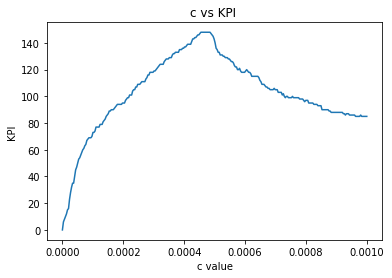

In [24]:
budget = 6250
optimal_basebid = 0
optimal_num_clicks = 0
num_won_auctions = 0
base_bids_array = []
num_clicks_array = []

avg_ctr = 7.375e-04 


# Line search to find optimal constant variable c, with fixed λ
for bid in np.linspace(0.0, 0.001, 300):
    validation_final['bid'] = ortb2(bid, lambda_ortb, predicted_XGB_CTR)
        
    Won_Auctions = validation_final[ (validation_final['bid'] >= validation_final['slotprice']) & (validation_final['bid'] >=validation_final['payprice']) ]
    exceeding_indexes = np.flatnonzero( (Won_Auctions['payprice'].cumsum().values) > budget  )
    
    # Budget exceeded
    if len(exceeding_indexes) > 0:
        # Gives the first index as soon as the sum of the payprice exceeds the budget
        ExceedBudget_Index = exceeding_indexes[0]
        # Only consider the won auctions UP to ExceedBudget_Index
        num_clicks = Won_Auctions[:ExceedBudget_Index]['click'].sum()
        budget_spent = Won_Auctions[:ExceedBudget_Index]['payprice'].sum()
        num_won_auctions = len(Won_Auctions[:ExceedBudget_Index])
   
    # No budget exceeded
    else:
        num_clicks = Won_Auctions[:]['click'].sum()
        budget_spent = Won_Auctions[:]['payprice'].sum()
        num_won_auctions = len(Won_Auctions[:])
    
    # Max clicks achieved --> optimal c
    if num_clicks > optimal_num_clicks:
        optimal_basebid = bid
        optimal_num_clicks = num_clicks
        optimal_impressions = num_won_auctions
        opt_budget = budget_spent
    
    print ('Without Budget limit: ', Won_Auctions['payprice'].sum(), 'Num Clicks: ',Won_Auctions['click'].sum() , 
           'With Budget limit: ', budget_spent, "Num Clicks: ", num_clicks , 
           "CTR: ", num_clicks/num_won_auctions, 'won impressions: ', num_won_auctions , "c ", bid)
    
    base_bids_array.append(bid)
    num_clicks_array.append(num_clicks)


# bids vs number of clicks, plot
plt.plot(base_bids_array, num_clicks_array)
plt.xlabel("c value")
plt.ylabel("KPI")
plt.title("c vs KPI ")
plt.show()


avgCPM = (opt_budget/optimal_impressions)*1000
avgCPC = (opt_budget/optimal_num_clicks)

optimal_bids = ortb2(optimal_basebid, lambda_ortb, predicted_XGB_CTR)


print ("Optimal c is: ", optimal_basebid, ", Optimal num clicks: ", optimal_num_clicks, ', impressions:', optimal_impressions)
print('budget spent:', opt_budget , ', avgCPM:', avgCPM, ', avgCPC:', avgCPC)
print('CTR: ' , (optimal_num_clicks/optimal_impressions)*100, '%')

## Optimal bids for the validation set


In [22]:
optimal_bids = optimal_bids * 1000
aaa = pd.DataFrame(optimal_bids)
aaa.to_csv('optimalbids_validation_ortb2.csv')

## Optimal bids for the test set

Similar steps of feature engineering must take place

In [22]:
def preprocess_df(df):

    
    #---real price-----    
    if 'bidprice' and 'payprice' in df.columns:
        df['bidprice'] = df['bidprice'].apply( lambda x: x/1000.0 )
        df['payprice'] = df['payprice'].apply( lambda x: x/1000.0 )
       
        
    #---slot area-----  
    df['slot_area']=df['slotwidth'] * df['slotheight'] 
    
    #----real price---   
    df['slotprice'] = df['slotprice'].apply( lambda x: x/1000.0 )
    
    
    # ----browser/OS splitting--    
    df['OS'] = df['useragent'].apply( lambda x: x.split('_')[0] )
    df['browser'] = df['useragent'].apply( lambda x: x.split('_')[1] ) 
    df['OS'] = df['OS'].astype('category')
    df['browser'] = df['browser'].astype('category')
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    
    
    df['advertiser'] = df['advertiser'].astype('category')
    df['adexchange'] = df['adexchange'].astype('category')
    df['city'] = df['city'].astype('category')
    df['region'] = df['region'].astype('category')
    df['weekday'] = df['weekday'].astype('category')

    return df   
        

def tag(df):
    df['usertag'] = df['usertag'].apply(lambda x: str(x).split(','))
    
    AllTags = np.array(df['usertag'])
    Tags = [tag for usertags in AllTags for tag in usertags]
    Tags = list(set(Tags))
    
    for t in Tags:
        df['usertag_' + t] = df['usertag'].apply(lambda x: int(t in x))
    
    return df


In [23]:
test_final = preprocess_df(test)
test_final = tag(test)

In [24]:
# Dropping the same columns as before, except for bidid
test_final = test_final.drop(columns = ['usertag', 'useragent', 'slotheight', 'slotwidth','urlid','IP', 'domain', 'url','slotid', 'keypage','userid', 'creative', 'slotvisibility','slotformat'])

In [25]:
test_final.shape

(303375, 80)

In [26]:
test_final_final = pd.DataFrame(0, index=range(0,len(test_final)), columns=list( train_final.columns ))

for col in train_final:
    if col in test_final:
        test_final_final[col] = np.array( test_final[col] )

In [27]:
test_final_final.shape

(303375, 80)

In [29]:
test_final_final['adexchange'] = test_final_final['adexchange'].fillna(4)
X_test = test_final_final.astype(float)
X_test = X_test.drop(columns = ['bidprice', 'payprice', 'click'])

test_pred = model_xgb.predict(X_test)


#### pCTR for the test set

In [30]:
test_pCTR = model_xgb.predict_proba(X_test)[:,1]
test_pCTR

array([0.15464635, 0.25799447, 0.01843025, ..., 0.01211043, 0.14158835,
       0.01245131], dtype=float32)

#### Recalibration of the pCTR

In [31]:
test_pCTR_final = test_pCTR/(test_pCTR+((1-test_pCTR)/w)) 
test_pCTR_final

array([1.3336581e-03, 2.5317755e-03, 1.3704824e-04, ..., 8.9481917e-05,
       1.2026303e-03, 9.2032140e-05], dtype=float32)

In [32]:
final_bids = ortb2(optimal_basebid, lambda_ortb, test_pCTR_final)

In [35]:
bbb = test[['bidid']]
bbb['bidprice'] = final_bids*1000
bbb.to_csv('Group_14_ortb2.csv', index=False)